In [1]:
%%html
<style>
    .white {
        background-color: #FFFFFF;
    }
    .important{
        background-color: #332773;
        color: #FFFFFF; /* impose la couleur du texte */
        padding: 1em;              /* espace interne pour l’aération */
        border-radius: 8px;  
    }
</style>

<div class="white">
<p align="center" style="display: flex; justify-content: center; align-items: flex-end; gap: 60px;">
  <img src="assets/city-of-london-logo.png" alt="CoL Logo" style="max-height:110px; width:auto;"/>
  <img src="assets/ibm-logo.png" alt="IBM Logo" style="max-height:110px; width:auto; margin-right:40px;"/>
  <img src="assets/nayaone-logo.png" alt="NayaOne Logo" style="max-height:80px; width:auto; margin-top:10px;"/>
</p>
</div>

<font size="+4">FF Quartic</font>

**Quantum Computing Hackathon 2025**, hosted by the **City of London Corporation** in partnership with **IBM**, and supported by **NayaOne**. 

Team members : 
Ali Abbassi, Chih-Kang Huang, Jui-Ting Lu, Jui-Ni Annie Lu

<font size="+2">Acknowledgement</font><br>
We would like to thank our IBM tutor, Roberto Lo Nardo, for his time and guidance. We also thank Neressa Culi for her assistance with the NayaOne platform, as well as all the organizers from the City of London.

<font size="+2">Roadmap</font>
* [Introduction](#-1.-Introduction)
    * [Originality](#Originality)
* [Environment Setup](#environment-setup)
* [QUBO Construction](#QUBO-contruction)
* [QUBO Approachs](#QUBO-Approachs)
    * [Brute Force](#brute-force)  
    * [Simulated Annealing](#simulated-annealing)
    * [Variational Quantum Eigensolver(VQE)](#vqe)
    * [QAOA](#qaoa)
* [Beyond QUBO Approachs](#-Beyond-QUBO-Approachs)
* [Conclusion](#conclusion)
> Alternatively, use the trigram icon ☰ on the left to toggle the menu and explore further sections.

Before we dive in, we recommend restarting the kernel and running all cells so that everything is set up and ready to go.

# Introduction


Portfolio optimization with realistic constraints is computationally hard: discrete asset choices, transaction costs, and diversification rules quickly lead to high-dimensional, non-convex problems. Classical solvers scale poorly as the number of assets grows, especially when incorporating risk measures such as covariance or Conditional Value at Risk (CVaR).

Banks, asset managers, insurers, and pension funds face these challenges daily. This project explores quantum optimization methods for such problems, benchmarking them against strong classical baselines. The goals are to assess how quantum approaches perform on objectives like diversification, downside protection, and capital efficiency, and to build tools that can accelerate adoption as hardware improves.

Our model combines mean–variance optimization with risk management in a **rolling-horizon** setting. At each step, expected returns and covariances are forecasted, portfolios are optimized under mean-variance with cardinality constraints, and the process repeats to adapt to changing markets. This discretized workflow approximates the continuous-time Hamilton–Jacobi–Bellman (HJB) equation, which is otherwise intractable in high dimensions.


## Our contributions

We propose a framework for Quantum Portfolio Optimization that translates financial decision problems into quantum formulations. Finance executives provide input parameters (e.g. assets, constraints, and objectives) and the framework outputs interpretable results: bitstrings that map directly to investment strategies. These bitstrings represent distinct solution paths in our optimization diagram, allowing decision-makers to visualize multiple strategic options. By bridging abstract quantum computations with actionable portfolio strategies, our framework makes cutting-edge quantum optimization accessible and relevant to business leaders.

To better illustrate the concept, we present the following *end-to-end quantum framework*: 

<div class="white">
    <img
  src="img/flowchart.svg"
  alt="flowchart"
  height="87"
  width=auto />
</div>

#### Pipeline (at a glance)
1. **Input**: assets, constraints, objectives.  
2. **Formulation**: map to *quantum-compatible* model.  
3. **Optimization**: solve with [VQE](#vqe), [QAOA](#qaoa), or [Annealing](#simulated-annealing).
4. **Output**: bitstrings → investment strategies.  
5. **Analysis**: interpretability, convergence, benchmarks.  

<h3 class="important">Originality</h3>
<div class="important"> 
The originality of our work is two-fold, by both applying quantum methods and designing an **end-to-end framework** that:

1. **Dynamic portfolio optimization:**  We extend the problem to account for fluctuations in both asset returns and covariances.
1. **Explicability:** From input specification to solver selection, we provide a structured pipeline that makes complex portfolio optimization problems transparent.  
1. **Simplifies decisions:**  Executives and researchers can clearly see how different formulations (QUBO, Ising, PUBO, HUBO) and algorithms (QAOA, VQE, VQA, Annealing) affect outcomes.  
1. **Highlights trade-offs:**  The framework shows the **limitations** (scalability, noise, embedding overhead) and **advantages:** (parallelism, expressivity, risk-adjusted gains) of each approach.  
1. **Guides quantum adoption:**  By benchmarking against strong classical baselines, we identify where quantum techniques provide added value and where classical still dominates.
1. **Theoretical scope beyond QUBO:** We outline a broader theoretical framework aimed at producing more precise Sharpe Ratios under realistic scenarios.

This end-to-end vision provides a **decision-support tool**: it reveals *where and how quantum optimization can be meaningfully introduced* in financial workflows.
</div>

> This notebook demonstrates a minimum viable product. We describe a **quantum-ready** pipeline which represents one path from our framework: combinatorial subproblems are mapped to QUBO form, enabling the use of Quantum Algorithms. Deliverables include:
>
>  - a reproducible hybrid pipeline,
>  - preliminary benchmarks versus classical solvers (exact and heuristic),
>  - approach-specific insights (IBM VQE/QAOA).
 

## Problem formulation

Let $N$ assets with expected returns $\mu\in\mathbb{R}^{N}$ and covariance $\Sigma\in\mathbb{R}^{N\times N}$. 
Classically, extensive research has been conducted on the mean–variance (MV) problem, as the following:
$$
\begin{align}
  \textbf{(P$_{\text{MV}}$)}\quad &\min_{x\in\{0,1\}^N} \quad x^{\top}\Sigma x - \lambda\, \mu^{\top}x \\
  & \text{s.t.}  \quad \|x\|_1 \le k,\ \text{(cardinality constraint)}
\end{align}
$$

Since the mean–variance problem $\textbf{(P$_{\text{MV}}$)}$ captures only a *static*, single-period allocation, we instead consider a more general **multi-period** optimization problem, where portfolio decisions account for future price fluctuations. In this setting, we are given a sequence of predicted returns and covariance matrices
<!-- Since the mean-variance problem $\textbf{(P$_{\text{MV}}$)}$ captures only ,
we tackle a **multi-period** optimization problem, where asset allocation takes into account future price fluctuations. Given a sequence of predicted returns and covariance matrices  -->
$$
      \left(  \mu_{0}, 
        \mu_{1}^\gamma,\mu_{1}^\gamma,\ldots \mu_{N_T-1}^\gamma, \Sigma_0,
        \Sigma_{1}^\gamma,\Sigma_{2}^\gamma,\ldots \Sigma_{N_T-1}^\gamma
        \right)
$$ where $\mu_i^\gamma$ and $\Sigma_i^\gamma$ denote the predicted returns and covariance matrices derived from the asset datasets.
We consider the following minimization problem:

$$
\begin{align}
\textbf{(P$_{\text{MV}}^\gamma$)}\quad &
  \min_{x\in [0,1]^{N_T \times N}} && 
  \sum_{t=0}^{N_T-1} c_t \left(
  x_{t}^{\top}\Sigma_{t}^\gamma x_{t} - \lambda\, 
  (\mu_{t}^\gamma)^{\top} x_{t}
  \right)
  +
  \sum_{t=1}^{N_T -1} \eta_t 
  \underbrace{\left(x_{t}-x_{t-1}\right)^2}_{\text{Transaction cost}}
  \\
  &\text{s.t.} && \|x_{t}\|_1 := \sum_{i=1}^N |x_{t, i}|=1,\ \forall t \in [0, \ldots N_T-1],
  %\label{eq:mv-card}
\end{align}
$$
where 
* $N_T$ denotes the number of time steps,
* $\mu_t \in \mathbb{R}^N$ is the **expected return vector**,
* $\Sigma_t \in \mathbb{R}^{N\times N}$ is the **covariance matrix** (symmetric positive semidefinite),
* $c_t$ denotes the causality or confidence coefficient associated to $\mu_t$ and $\Sigma_t$,
* $\lambda \geq 0$ is the **risk-aversion parameter**,
* $\eta_t >0$ the **transaction coefficiant** between times $t$ and $t-1$.


> **Remark:** In practice, this is solved in a rolling manner: each day we compute the optimization and apply only the first-step allocation $x_{0}$. The forecasts are then updated with new data for the following day’s allocation.


The optimization problem is cast into a [**Quadratic Unconstrained Binary Optimization (QUBO)** problem](#QUBO).

# Environment Setup

Run the following cells to set up the notebook.

In [2]:
!./utils/notebook_setup.sh > /dev/null >> /dev/null

In [3]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_bloch_vector, plot_histogram
from qiskit.quantum_info import Statevector

import time

# our own stuffs
from utils.utility import * # custom functions
from utils.myplot import * # plot funtions
from utils.portfolio_model import * # portfolio_model class and toy cases

# QUBO contruction

> The **Quadratic Unconstrained Binary Optimization (QUBO)** formulation is introduced as a bridge between problems and solvers. In this section, we explain how the time depended dataset is adapted and encoded into this standardized representation, enabling it to be processed by both classical and quantum optimization methods.
 
The straightforward translation of the problem into QUBO is to represent each asset as a single binary variable. The variable takes the value 1 if the asset is included in the portfolio and 0 otherwise. Here, we would like to extend this idea by introducing a binary encoding scheme between 0 and 1, allowing for a more fine-grained selection of assets in the portfolio.

## Binary Encoding
For every time $t \in \{0,1\}$, asset $i \in \{1,\dots,N\}$, we write the portfolio weights $x_{t,i}\in [0, 1]$ as a linear combination of binary variables $x_{t,i,q}$ for every bit $q \in \{0,\dots,N_q\}$. Namely, we have
$$
x_{t,i} \;=\; \Delta \sum_{q=0}^{N_q} 2^q\, x_{t,i,q},
\qquad x_{t,i,q}\in\{0,1\}
\qquad \text{with }\Delta = \frac{1}{2^{N_q+1}-1}.
$$


This encoding has an obvious drawback: it significantly increases the number of required qubits. Therefore, in the following example, we limit the precision to $N_q=1$ or $N_q=2$.

## Cost Function
We scale down our problem by considering the case $N=10$ and horizon $N_T=1$.
The portfolio allocation variables are binary-encoded with $N_q+1$ bits per asset.

The optimization problem becomes:

$$
C(x) \;=\; \sum_{t=0}^1 c_t \Big( x_t^\top \Sigma_t x_t - \lambda\, \mu_t^\top x_t \Big)
\;+\; \eta_0 \,\|x_1 - x_0\|_2^2
\;+\; A_0 \Big(\sum_i x_{0,i}-1\Big)^2
\;+\; A_1 \Big(\sum_i x_{1,i}-1\Big)^2.
$$

Here:
* $c_0 > c_1 > 0$ are **time-dependent weights**,
* $\mu_t \in \mathbb{R}^N$ is the **expected return vector**,
* $\Sigma_t \in \mathbb{R}^{N\times N}$ is the **covariance matrix** (symmetric positive semidefinite),
* $\lambda \geq 0$ is the **risk-aversion parameter**,
* $\eta_0 \geq 0$ **transaction coefficient** between times $t=0$ and $t=1$,
* $A_0,A_1 > 0$ **enforce the budget constraints** at each time.


### Bit-Level Expansion
After substituting the binary encoding, all terms remain quadratic in the binary variables $x_{t,i,q}$:

## Toy cases

### First case: Two assets
We start by a tiny <font size="-2">tiny</font> model with only two assets and randomly set parameters.

In [4]:
portfolio_toycase = create_toy_example()
portfolio_toycase.summary()

Portfolio Model Summary:
  Number of assets      : 2
  Number of time steps  : 2
  λ (lambda)            : 1.0
  Nq (binary encoding)  : 1
  mu_list               : [array([0.1 , 0.05]), array([0.08, 0.04])]
  Sigma_list            : [array([[0.02, 0.01],
       [0.01, 0.02]]), array([[0.03 , 0.01 ],
       [0.01 , 0.025]])]
  c_list                : [1.0, 0.5]
  eta_list              : [0.1]
  A_list                : [5.0, 5.0]


In [5]:
# Build QUBO
bqm, H, order, offset = build_qubo_dynamic_from_portfolio_model(portfolio_toycase)
print("Variables:", order)
print("H shape   :", H.shape)
print("Offset    :", offset)

Variables: [('x', 0, 0, 0), ('x', 0, 0, 1), ('x', 0, 1, 0), ('x', 0, 1, 1), ('x', 1, 0, 0), ('x', 1, 0, 1), ('x', 1, 1, 0), ('x', 1, 1, 1)]
H shape   : (8, 8)
Offset    : 10.0


Solving with exact solver

In [6]:
sampler = ExactSolver()
sampleset = sampler.sample(bqm)

In [7]:
df = process_sampleset(sampleset, order, portfolio_toycase.mu_list, portfolio_toycase.Nq, offset=0, decode_func=decode)
df.head()

,bitstring,energy_raw,energy_shifted,occurrences,x0,x1,energy_percentage,x0_diff,x1_diff
0,"[1, 1, 0, 0, 1, 1, 0, 0]",-10.105000,-10.105000,1,"[1.0, 0.0]","[1.0, 0.0]",0.0,"[0.0, 0.0]","[0.0, 0.0]"
1,"[0, 1, 1, 0, 0, 1, 1, 0]",-10.090833,-10.090833,1,"[0.6666666666666666, 0.3333333333333333]","[0.6666666666666666, 0.3333333333333333]",0.1,"[-0.33333333333333337, 0.3333333333333333]","[-0.33333333333333337, 0.3333333333333333]"
2,"[1, 1, 0, 0, 0, 1, 1, 0]",-10.080833,-10.080833,1,"[1.0, 0.0]","[0.6666666666666666, 0.3333333333333333]",0.2,"[0.0, 0.0]","[-0.33333333333333337, 0.3333333333333333]"
3,"[0, 1, 1, 0, 1, 1, 0, 0]",-10.070556,-10.070556,1,"[0.6666666666666666, 0.3333333333333333]","[1.0, 0.0]",0.3,"[-0.33333333333333337, 0.3333333333333333]","[0.0, 0.0]"
4,"[1, 0, 0, 1, 1, 0, 0, 1]",-10.068333,-10.068333,1,"[0.3333333333333333, 0.6666666666666666]","[0.3333333333333333, 0.6666666666666666]",0.4,"[-0.6666666666666667, 0.6666666666666666]","[-0.6666666666666667, 0.6666666666666666]"


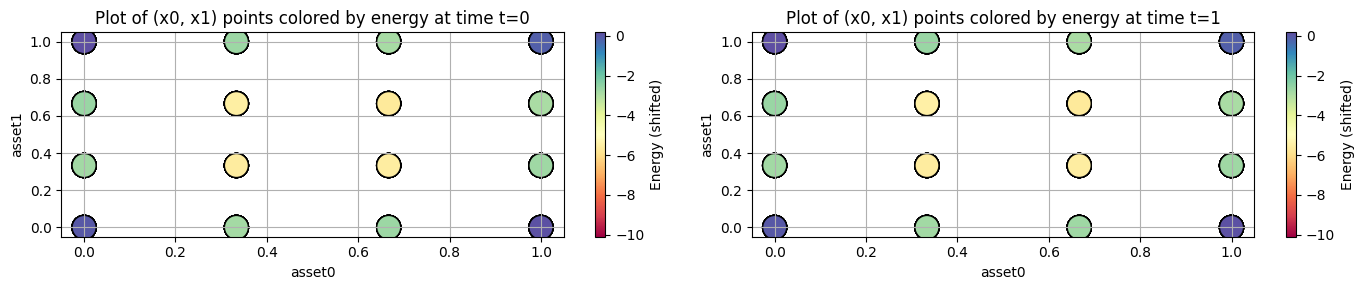

In [8]:
#plot_x0_x1_energy(df)
fig, axes = plt.subplots(1, 2, figsize=(14, 3))
plot_x0_x1_energy_by_time(df, max_size=300, t=0, figsize=(8,6), cmap='Spectral', ax=axes[0])
plot_x0_x1_energy_by_time(df, max_size=300, t=1, figsize=(8,6), cmap='Spectral', ax=axes[1])
plt.tight_layout()
plt.show()

The following solution preserves feasibility, since the constraints are not violated:

In [9]:
best = sampleset.first
x= decode_solution(best.sample, N=2, Nq=1)
#print("Decoded x0:", x[0], " sum =", x0.sum())
for t in range(2):
    print(f"Decoded x{t}: {x[t]}, sum = {x[t].sum()}")

Decoded x0: [1. 0.], sum = 1.0
Decoded x1: [1. 0.], sum = 1.0


### Second case: Ten stocks
We select 10 stocks from Yahoo Finance's dataset. We apply a rolling window of 60 days to compute the mean and covariance of 2 days (yesterday and today).

In [10]:
# Example tickers
tickers = ["AAPL", "MSFT", "GOOGL", "TSLA", "AMZN", "NVDA", "GS", "MS", "KO", "NKE"]
# Download adjusted close prices (daily, last 2 years)
data = yf.download(tickers, period="2y", auto_adjust=True)["Close"]

returns = np.log(data / data.shift(1)).dropna() # Compute log returns
window = 60
rolling_mean = returns.rolling(window).mean()
rolling_cov = returns.rolling(window).cov()

# --- Example: get estimates "today" and "tomorrow" ---
today, yesterday = returns.index[-1], returns.index[-2]
mu_today, cov_today = rolling_mean.loc[today], rolling_cov.loc[today] 
mu_yesterday, cov_yesterday = rolling_mean.loc[yesterday], rolling_cov.loc[yesterday]

[*********************100%***********************]  10 of 10 completed


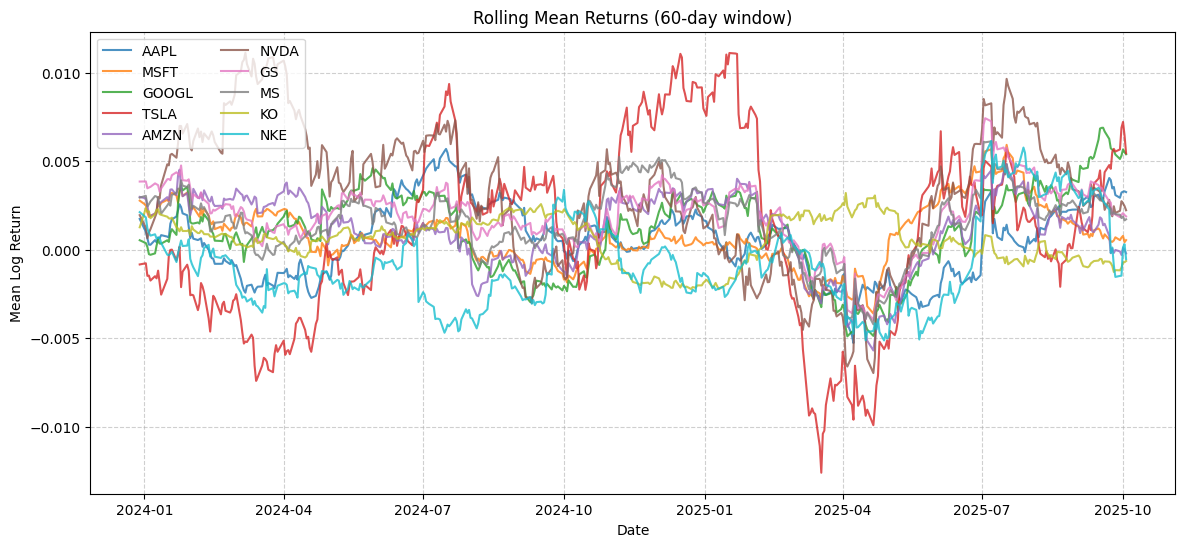

In [11]:
plot_rolling_mean(rolling_mean,tickers)

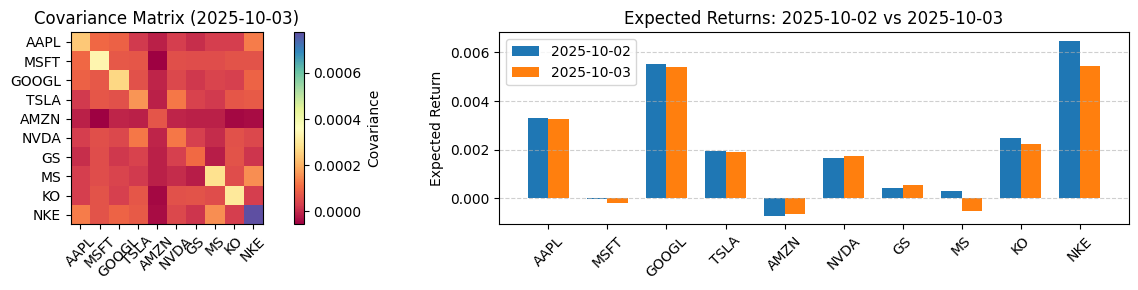

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 3))
plot_covariance_day(cov_today,today,tickers, ax=axes[0])
plot_compare_expected_returns(mu_yesterday,mu_today,yesterday,today,tickers, ax=axes[1])
plt.tight_layout()
plt.show()

In [13]:
portfolio_stocks = create_finance_example()
portfolio_stocks.short_summary()

[*********************100%***********************]  10 of 10 completed

Portfolio Model Summary:
  Number of assets      : 10
  Number of time steps  : 2
  λ (lambda)            : 1.0
  Nq (binary encoding)  : 1
  c_list                : [1.0, 0.5]
  eta_list              : [0.1]
  A_list                : [5.0, 5.0]


In [14]:
# Build QUBO
bqm, H, order, offset = build_qubo_dynamic_from_portfolio_model(portfolio_stocks)
print("Variables:", order)
print("H shape   :", H.shape)
print("Offset    :", offset)

Variables: [('x', 0, 0, 0), ('x', 0, 0, 1), ('x', 0, 1, 0), ('x', 0, 1, 1), ('x', 0, 2, 0), ('x', 0, 2, 1), ('x', 0, 3, 0), ('x', 0, 3, 1), ('x', 0, 4, 0), ('x', 0, 4, 1), ('x', 0, 5, 0), ('x', 0, 5, 1), ('x', 0, 6, 0), ('x', 0, 6, 1), ('x', 0, 7, 0), ('x', 0, 7, 1), ('x', 0, 8, 0), ('x', 0, 8, 1), ('x', 0, 9, 0), ('x', 0, 9, 1), ('x', 1, 0, 0), ('x', 1, 0, 1), ('x', 1, 1, 0), ('x', 1, 1, 1), ('x', 1, 2, 0), ('x', 1, 2, 1), ('x', 1, 3, 0), ('x', 1, 3, 1), ('x', 1, 4, 0), ('x', 1, 4, 1), ('x', 1, 5, 0), ('x', 1, 5, 1), ('x', 1, 6, 0), ('x', 1, 6, 1), ('x', 1, 7, 0), ('x', 1, 7, 1), ('x', 1, 8, 0), ('x', 1, 8, 1), ('x', 1, 9, 0), ('x', 1, 9, 1)]
H shape   : (40, 40)
Offset    : 10.0


# QUBO 

> In this section, we outline different techniques to solve QUBOs, providing a panorama of both classical and hybrid quantum methods. Some of the implementations presented are currently executed through quantum simulation, but we hope to adapt and extend them for execution on real quantum hardware in the future.

We selected two quantum methods, [VQE](#VQE) and [QAOA](#QAOA), both of which fall under the class of Variational Quantum Algorithms (VQAs). The following flowchart illustrates the core idea of each algorithm in a simplified form.

In [15]:
from mermaid import Mermaid
Mermaid("""
    graph LR
    VAQ["Variational Quantum Algorithms for Quantum (VQA)"] --> VQE["Variational Quantum Eigensolver (VQE)"]
    VAQ --> QAOA["Quantum Approximate Optimization Algorithm (QAOA)"]
    
    VQE --> VQE_Input["Input: Hamiltonian H, Ansatz circuit"]
    VQE --> VQE_Opt["Classical Optimizer"]
    VQE --> VQE_Output["Output: Ground state energy estimate"]
    
    QAOA --> QAOA_Input["Input: Cost Hamiltonian C, Mixer Hamiltonian M, p-depth"]
    QAOA --> QAOA_Opt["Classical Optimizer for angles γ, β"]
    QAOA --> QAOA_Output["Output: Approximate solution to combinatorial problem"]

""")

## Brute Force

For comparison, we begin with the brute force method. This approach explores every point in the solution space and identifies the minimum by direct comparison. While straightforward, the computational speed explodes exponentially, and we recommend using it only with our toy example or a small number of assets.

In [16]:
start = time.time()
portfolio = create_toy_example() 
# portfolio = create_finance_example() # will take a longtime
bqm, H, order, offset = build_qubo_dynamic_from_portfolio_model(portfolio)
sampler = ExactSolver()
sampleset = sampler.sample(bqm)
best = sampleset.lowest()
end = time.time()
print(f"Total timelap : {end-start}")
print(" =============================== ")
best = sampleset.lowest()
bits = best.record.sample[0]
bitstring = "".join(str(b) for b in bits)
decoded = portfolio.decode(bits)
print(" ===== Brute force result: ===== ")
print(f"Best result (bitstring): {bitstring}")
portfolio.show_decode(decoded)

Total timelap : 0.0012440681457519531
 ===== Brute force result: ===== 
Best result (bitstring): 11001100
              asset1    asset2
       t=0     1.000     0.000
       t=1     1.000     0.000


## Simulated Annealing

As another point of comparison, we also present how a QUBO problem can be solved using the simulated annealing method, a classical heuristic inspired by thermodynamics that provides efficient approximations for larger instances.

In [17]:
from dwave.samplers import SimulatedAnnealingSampler
portfolio = create_finance_example()
bqm, H, order, offset = build_qubo_dynamic_from_portfolio_model(portfolio) 
sampler = SimulatedAnnealingSampler()
sampleset = sampler.sample(bqm, num_reads=1000)

# Collapse duplicates to see num_occurrences properly
sampleset = sampleset.aggregate()

print(" ===== Simulated annealing result: ===== ")
best = sampleset.first
print(f"Best energy: {best.energy} with {best.num_occurrences} occurrence(s).")
best_sample = [best.sample[v] for v in order]
bitstring = "".join(str(b) for b in best_sample)
print(f"SA bitstring: {bitstring}")
decoded = portfolio.decode(bitstring)
portfolio.show_decode(decoded,precision=5)

#print(sampleset.aggregate())   # groups identical bitstrings with num_occurrences

[*********************100%***********************]  10 of 10 completed


 ===== Simulated annealing result: ===== 
Best energy: -10.006132617674297 with 1 occurrence(s).
SA bitstring: 1000000000000000101010000000000000001010
              asset1    asset2    asset3    asset4    asset5    asset6    asset7    asset8    asset9   asset10
       t=0   0.33333   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
       t=1   0.33333   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000


## VQE 
> Variational Quantum Eigensolver

The **Variational Quantum Eigensolver (VQE)** is a hybrid quantum-classical algorithm used to approximate the ground state energy of a Hamiltonian.  
It prepares a parameterized quantum state $|\psi(\theta)\rangle$ and minimizes the expected energy:

$$
E(\theta) = \langle \psi(\theta) | H | \psi(\theta) \rangle
$$

using a classical optimizer to update the parameters $\theta$.  
VQE leverages shallow quantum circuits, making it suitable for current noisy intermediate-scale quantum (NISQ) devices.


### Implementation
We transform our QUBO into an Ising hamiltonian which is expressed as a linear combination of Pauli matrices.

In [18]:
from mermaid import Mermaid
Mermaid("""
flowchart LR
    A("Step 1: QUBO") --> B("Step 2: Hamiltonian")
    B --> C("Step 3: Pauli Matrices")
        """)

In [19]:
tickers = ["AAPL", "MSFT", "GOOGL", "TSLA", "AMZN", "NVDA", "GS", "MS", "KO", "NKE"]
portfolio = create_finance_example(tickers=tickers[:2]) # Kernal will die if too much assets
bqm, H, order, offset = build_qubo_dynamic_from_portfolio_model(portfolio)
linear, quadratic, offset = bqm.to_ising()
order = list(bqm.variables)                # bqm.variables gives your [('x',t,i,q), ...]
index_of = {v: k for k, v in enumerate(order)}

# Now convert to Pauli Hamiltonian
cost_h, const = ising_to_pauli(linear, quadratic, offset, index_of)

print(" ===== Qiskit SparsePauliOp Hamiltonian: ======")
print(f"Cost Hamiltonian: {cost_h}")
print(f"Constant offset: {const}")
A = np.array(cost_h)
eigenvalues, eigenvectors = np.linalg.eigh(A)
ref_value = min(eigenvalues)
print(f"The ground state energy is {ref_value}")

[*********************100%***********************]  2 of 2 completed

 ===== Qiskit SparsePauliOp Hamiltonian: ======
Cost Hamiltonian: SparsePauliOp(['IIIIIIIZ', 'IIIIIIZI', 'IIIIIZII', 'IIIIZIII', 'IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII', 'IIIIIIZZ', 'IIIIIZIZ', 'IIIIIZZI', 'IIIIZIIZ', 'IIIIZIZI', 'IIIIZZII', 'IIIZIIIZ', 'IIIZIIZI', 'IIZIIIIZ', 'IIZIIIZI', 'IIZZIIII', 'IZIIIZII', 'IZIIZIII', 'IZIZIIII', 'IZZIIIII', 'ZIIIIZII', 'ZIIIZIII', 'ZIIZIIII', 'ZIZIIIII', 'ZZIIIIII'],
              coeffs=[-5.06363348e-04+0.j, -1.01272670e-03+0.j, -1.11903895e-04+0.j,
 -2.23807790e-04+0.j, -2.54900567e-04+0.j, -5.09801134e-04+0.j,
 -2.63898529e-05+0.j, -5.27797058e-05+0.j,  5.66693184e-01+0.j,
  2.77778144e-01+0.j,  5.55556289e-01+0.j,  5.55556289e-01+0.j,
  1.11111258e+00+0.j,  5.66678532e-01+0.j, -5.55555556e-03+0.j,
 -1.11111111e-02+0.j, -1.11111111e-02+0.j, -2.22222222e-02+0.j,
  5.66679931e-01+0.j, -5.55555556e-03+0.j, -1.11111111e-02+0.j,
  2.77777935e-01+0.j,  5.55555871e-01+0.j, -1.11111111e-02+0.j,
 -2.22222222e-02+0.j,  5.55555871e-01+0.j,  1.111

The following examples will all use the same ansatz *efficient su2* and a gradient-free optimizer *COBYLA*, defined as follows:

This circuit has 16 parameters


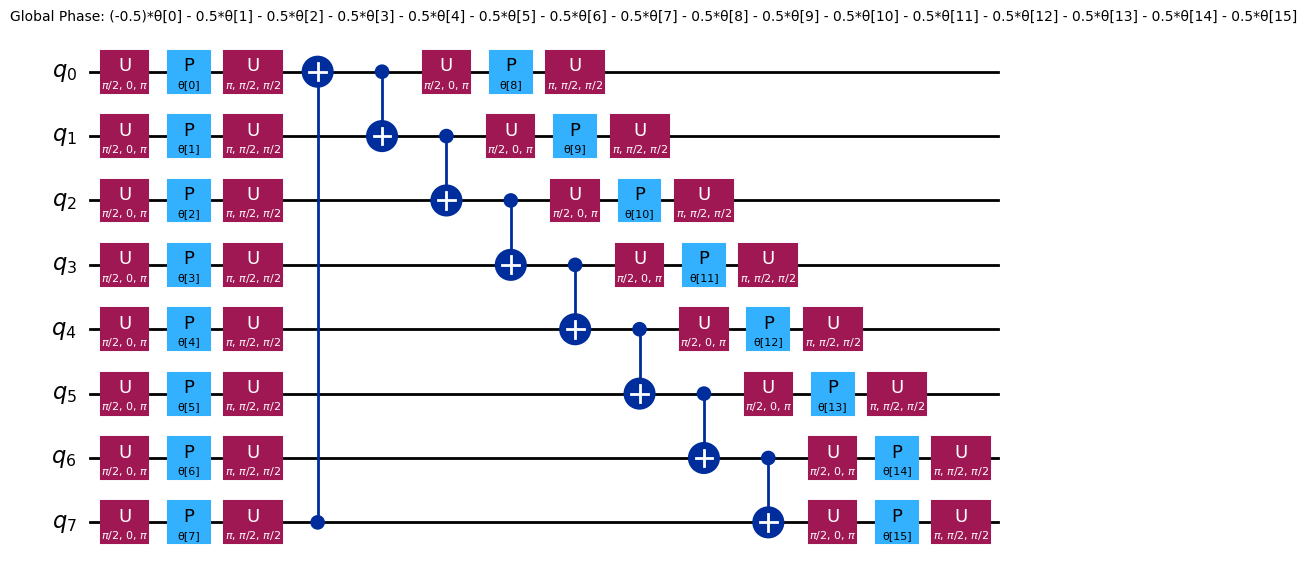

In [20]:
# define ansatz and optimizer
from qiskit_algorithms.optimizers import SPSA, COBYLA
from qiskit.circuit.library import efficient_su2

# Note that it is more common to place initial 'h' gates outside the ansatz. Here we specifically wanted this layer structure.
ansatz = efficient_su2(
    cost_h.num_qubits, su2_gates=["h", "rz", "y"], entanglement="circular", reps=1
)
optimizer = COBYLA(maxiter=200)  # lightweight, gradient-free
num_params = ansatz.num_parameters
print(f"This circuit has {num_params} parameters")
 
ansatz.decompose().draw("mpl", style="iqp")

In [21]:
# define callback
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

In [22]:
# define Aer Estimator for noiseless statevector simulation
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer.primitives import EstimatorV2 as AerEstimator
from qiskit_algorithms import VQE
from qiskit.quantum_info import Statevector

# initialize callback
counts = []
values = []

seed = 170
algorithm_globals.random_seed = seed

noiseless_estimator = AerEstimator(options={"default_precision": 1e-2})

vqe = VQE(noiseless_estimator, ansatz, optimizer=optimizer, callback=store_intermediate_result)
print(" ===== Starting VQE ===== ")
result = vqe.compute_minimum_eigenvalue(operator=cost_h)
print(f"VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}")
print(f"Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}")

# Bind optimal parameters into ansatz
optimal_params = result.optimal_point
optimal_circuit = ansatz.assign_parameters(optimal_params)

# Get statevector and probability
state = Statevector.from_instruction(optimal_circuit)
probs = state.probabilities_dict()

# After computing probs = state.probabilities_dict()
max_state = max(probs, key=probs.get)   # basis state with max probability
max_prob  = probs[max_state]            # its probability

print("Most likely state:", max_state)
print("Probability:", max_prob)

counts_no_noise = counts
values_no_noise = values

 ===== Starting VQE ===== 
VQE on Aer qasm simulator (no noise): -2.78588
Delta from reference energy value is 0.04927
Most likely state: 01100110
Probability: 0.9125018498835501


### Performance *without* backend noise
Let's first run the `VQE` on the default Aer simulator without adding noise from the backend. We'll still specify a target precision to simulate shot noise. This result should be relatively close to the reference value from the exact computation.

In [23]:
from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import GenericBackendV2

# initialize callback
counts = []
values = []

coupling_map = [(0, 1), (1, 2), (2, 3), (3, 4)]
device = GenericBackendV2(num_qubits=5, coupling_map=coupling_map, seed=54)

noise_model = NoiseModel.from_backend(device)

noisy_estimator = AerEstimator(
    options={
        "default_precision": 1e-2,
        "backend_options": {
            "method": "density_matrix",
            "coupling_map": coupling_map,
            "noise_model": noise_model,
        },
    }
)

vqe = VQE(noiseless_estimator, ansatz, optimizer=optimizer, callback=store_intermediate_result)
print(" ===== Starting VQE ===== ")
result = vqe.compute_minimum_eigenvalue(operator=cost_h)
print(f"VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}")
print(f"Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}")

# Bind optimal parameters into ansatz
optimal_params = result.optimal_point
optimal_circuit = ansatz.assign_parameters(optimal_params)

# Get statevector and probability
state = Statevector.from_instruction(optimal_circuit)
probs = state.probabilities_dict()

# After computing probs = state.probabilities_dict()
max_state = max(probs, key=probs.get)   # basis state with max probability
max_prob  = probs[max_state]            # its probability

print("Most likely state:", max_state)
print("Probability:", max_prob)

counts_noisy = counts
values_noisy = values

 ===== Starting VQE ===== 
VQE on Aer qasm simulator (no noise): -2.14711
Delta from reference energy value is 0.68804
Most likely state: 00101001
Probability: 0.9103364802237998


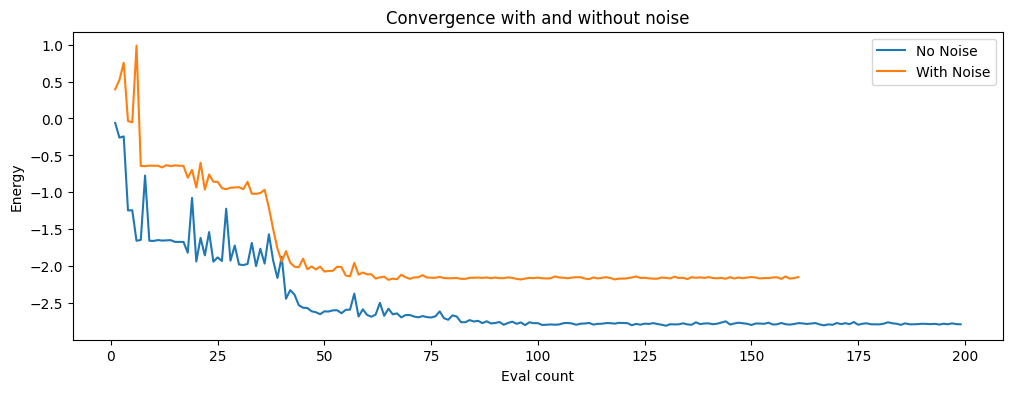

In [24]:
import pylab
pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts_no_noise, values_no_noise, label="No Noise")
pylab.plot(counts_noisy, values_noisy, label="With Noise")
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Convergence with and without noise")
pylab.legend()

## QAOA
> Quantum approximate optimization algorithm

The **Quantum Approximate Optimization Algorithm (QAOA)**, proposed by Farhi et al.[1], is a quantum-classical hybrid algorithm designed for gate-based quantum computers. Conceptually related to quantum annealing and based on the adiabatic theorem, QAOA uses real-valued parameters $\gamma = (\gamma_1, ..., \gamma_p)$ and $\beta = (\beta_1, ..., \beta_p)$, where the hyperparameter $p \in \mathbb{N}$ controls the algorithm’s depth.

The algorithm begins with the uniform superposition state $|+\rangle^n$ and evolves it as:

$$
|\psi(\beta, \gamma)\rangle = e^{-i\beta_p H_M} e^{-i\gamma_p H_C} \cdots e^{-i\beta_1 H_M} e^{-i\gamma_1 H_C} |+\rangle^n.
$$

Here, $H_C$ is the **problem Hamiltonian** encoding the QUBO cost function:
$$
\forall x \in \{0,1\}^n, \quad H_C |x\rangle = C(x) |x\rangle
$$
and $H_M$ is the **mixing Hamiltonian**, often set to be the *Transverse-field Hamiltonian*:
$$
H_M = \sum_i X_i,
$$
sum of $X$ gates. 

In [25]:
portfolio = create_toy_example() 
# tickers = ["AAPL", "MSFT", "GOOGL", "TSLA", "AMZN", "NVDA", "GS", "MS", "KO", "NKE"]
# portfolio = create_finance_example(tickers=tickers[:2]) # Kernal will die if too much assets
bqm, H, order, offset = build_qubo_dynamic_from_portfolio_model(portfolio)
linear, quadratic, offset = bqm.to_ising()
order = list(bqm.variables)                # bqm.variables gives your [('x',t,i,q), ...]
index_of = {v: k for k, v in enumerate(order)}

# Convert to Pauli Hamiltonian
cost_h, const = ising_to_pauli(linear, quadratic, offset, index_of)

print(" ===== Qiskit SparsePauliOp Hamiltonian: ======")
print(f"Cost Hamiltonian: {cost_h}")
print(f"Constant offset: {const}")
A = np.array(cost_h)
eigenvalues, eigenvectors = np.linalg.eigh(A)
print(f"The ground state energy is {min(eigenvalues)}")

 ===== Qiskit SparsePauliOp Hamiltonian: ======
Cost Hamiltonian: SparsePauliOp(['IIIIIIIZ', 'IIIIIIZI', 'IIIIIZII', 'IIIIZIII', 'IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII', 'IIIIIIZZ', 'IIIIIZIZ', 'IIIIIZZI', 'IIIIZIIZ', 'IIIIZIZI', 'IIIIZZII', 'IIIZIIIZ', 'IIIZIIZI', 'IIZIIIIZ', 'IIZIIIZI', 'IIZZIIII', 'IZIIIZII', 'IZIIZIII', 'IZIZIIII', 'IZZIIIII', 'ZIIIIZII', 'ZIIIZIII', 'ZIIZIIII', 'ZIZIIIII', 'ZZIIIIII'],
              coeffs=[-1.16666667e-02+0.j, -2.33333333e-02+0.j, -3.33333333e-03+0.j,
 -6.66666667e-03+0.j, -3.33333333e-03+0.j, -6.66666667e-03+0.j,
 -4.16666667e-04+0.j, -8.33333333e-04+0.j,  5.68888889e-01+0.j,
  2.78333333e-01+0.j,  5.56666667e-01+0.j,  5.56666667e-01+0.j,
  1.11333333e+00+0.j,  5.68888889e-01+0.j, -5.55555556e-03+0.j,
 -1.11111111e-02+0.j, -1.11111111e-02+0.j, -2.22222222e-02+0.j,
  5.68333333e-01+0.j, -5.55555556e-03+0.j, -1.11111111e-02+0.j,
  2.78055556e-01+0.j,  5.56111111e-01+0.j, -1.11111111e-02+0.j,
 -2.22222222e-02+0.j,  5.56111111e-01+0.j,  1.112

In [26]:
from qiskit import transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as AerEstimator, SamplerV2 as AerSampler
from scipy.optimize import minimize
from qiskit.circuit.library import QAOAAnsatz 

# ---------- Step 0: sanity + diagonality (QAOA expects Z/I-only cost terms)
def assert_diagonal_sparse_pauli(op: SparsePauliOp):
    # Diagonal in computational basis iff no X or Y appears in any term.
    # In Qiskit’s Pauli encoding, any X- or Y-presence sets the 'x' bit.
    if not isinstance(op, SparsePauliOp):
        raise TypeError("cost_h must be a qiskit.quantum_info.SparsePauliOp in Qiskit 2.x.")
    if hasattr(op, "paulis") and hasattr(op.paulis, "x") and np.any(op.paulis.x):
        raise ValueError("cost_h must be diagonal (Z/I only). Found X or Y in some terms.")
    return op

cost_h = assert_diagonal_sparse_pauli(cost_h)  # <- uses your existing variable

 ===== QAOA ansatz from your Hamiltonian ==== 
num_qubits      : 8
num_parameters  : 4
gate_count      : 80
depth           : 22
 ===== Decompose + Transpile to Aer basis ==== 
Total timelap : 0.5957028865814209
 ===== Set initial parameters ==== 
 ===== Set objective with EstimatorV2 ==== 
 ===== Classical optimization ==== 
Total timelap : 13.17745566368103
   Normal return from subroutine COBYLA


   NFVALS =   50   F =-2.013293E+00    MAXCV = 0.000000E+00
   X = 1.224664E+00   1.500934E+00   3.463886E-01   4.044002E-01


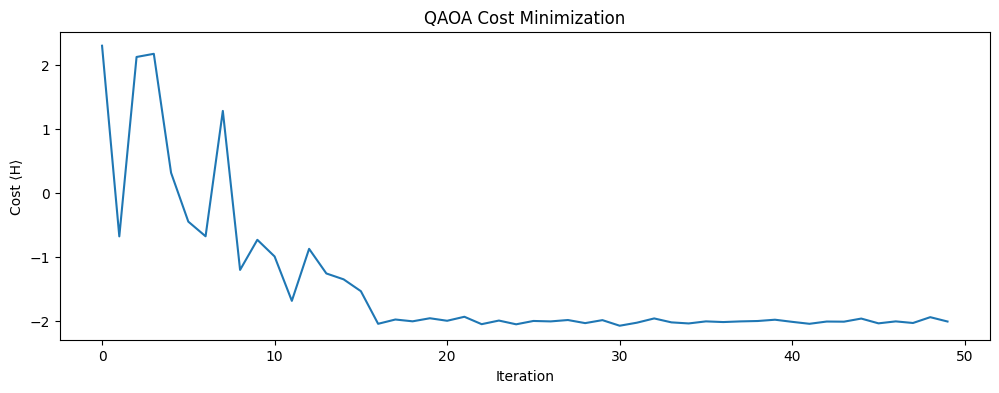

Optimized parameters: [1.22466404 1.5009338  0.34638857 0.40440016]
Final cost value ⟨H⟩: -2.0132929144965277
 ===== Sampling with optimized parameters (SamplerV2)  ==== 
Total timelap : 0.07138538360595703


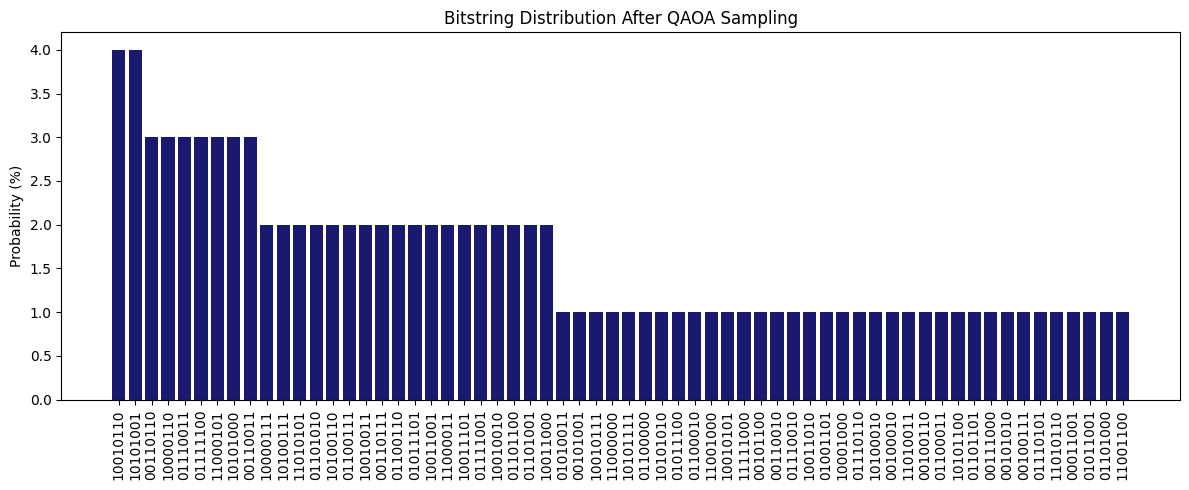

In [27]:
print(" ===== QAOA ansatz from your Hamiltonian ==== ")
p = 2  # QAOA depth
# flatten=True avoids nested gate objects; we’ll still decompose + transpile after.  :contentReference[oaicite:1]{index=1}
ansatz = QAOAAnsatz(cost_operator=cost_h, reps=p, name="qaoa", flatten=True)
assert ansatz.num_parameters == 2*p # Initial point length must be 2p.
print(f"num_qubits      : {ansatz.num_qubits}")
print(f"num_parameters  : {ansatz.num_parameters}")
print(f"gate_count      : {ansatz.size()}")
print(f"depth           : {ansatz.depth()}")
ansatz.measure_all()
ansatz.draw("mpl")
plt.show()

print(" ===== Decompose + Transpile to Aer basis ==== ")
start = time.time()
backend = AerSimulator()
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
# Extra safeguard: decompose composite instructions (e.g., evolution gates) before preset PM
candidate_circuit = pm.run(ansatz.decompose(reps=1))
# Final pass through transpile (belt-and-suspenders), fixes "unknown instruction: QAOA" in Aer
candidate_circuit = transpile(candidate_circuit, backend=backend, optimization_level=1)
end = time.time()
print(f"Total timelap : {end-start}")

print(" ===== Set initial parameters ==== ") # [β_0..β_{p-1}, γ_0..γ_{p-1}] (QAOAAnsatz uses this ordering)
# init_params = [np.pi/2]*p + [np.pi/4]*p
np.random.seed(0)
init_params = np.random.uniform(-np.pi, np.pi, size=2*p)
# init_params = np.random.uniform(0, np.pi/2, size=2*p)  #reduced search space

print(" ===== Set objective with EstimatorV2 ==== ")  # (exact EV on Aer unless you request precision)
estimator = AerEstimator()  # default exact expectation (no shots); set options={"default_precision": ...} to sample
objective_vals = []
def objective(params):
    # Map observable to physical layout chosen by the transpiler, per EstimatorV2 docs. :contentReference[oaicite:2]{index=2}
    # SA (Instruction Set Architecture) form, consistent with the actual circuit wiring.
    isa_h = cost_h.apply_layout(candidate_circuit.layout) #the mapping from logical qubits → physical qubits chosen during transpilation.
    job = estimator.run([(candidate_circuit, isa_h, [params])])  # one PUB
    pub_res = job.result()[0]
    ev = float(np.asarray(pub_res.data.evs)[0])  # scalar expectation value
    objective_vals.append(ev)
    return ev
    
print(" ===== Classical optimization ==== ") # (COBYLA ignores 'bounds'; use L-BFGS-B if you want bounds)
start = time.time()
result = minimize(objective, x0=np.array(init_params), method="COBYLA",
                  options={"maxiter": 500, "disp": True})
end = time.time()
print(f"Total timelap : {end-start}")

plt.plot(objective_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost ⟨H⟩")
plt.title("QAOA Cost Minimization")
plt.show()

print(f"Optimized parameters: {result.x}")
print(f"Final cost value ⟨H⟩: {result.fun}")

print(" ===== Sampling with optimized parameters (SamplerV2)  ==== ")
start = time.time()
optimized = candidate_circuit.assign_parameters(result.x, inplace=False)
sampler = AerSampler(default_shots=100, seed=42)
job = sampler.run([(optimized,)])  # one PUB: just the circuit
samples = job.result()[0]
end = time.time()
print(f"Total timelap : {end-start}")

counts = samples.data.meas.get_counts()
shots = samples.data.meas.num_shots
final_distribution = {bit: c/shots for bit, c in counts.items()}

# Visualize the distribution (sorted by probability)
sorted_items = sorted(final_distribution.items(), key=lambda x: -x[1])
bitstrings, probs = zip(*sorted_items)

plt.figure(figsize=(12, 5))
plt.bar(bitstrings, [p * 100 for p in probs], color="midnightblue")
plt.xticks(rotation=90)
plt.ylabel("Probability (%)")
plt.title("Bitstring Distribution After QAOA Sampling")
plt.tight_layout()
plt.show()

In [28]:
# final param [ 3.55979325  0.42546681 -2.24576941 -1.16927585]
best_bitstring = max(final_distribution, key=final_distribution.get)
print(f"Best bitstring: {best_bitstring}")
print(f"Probability: {final_distribution[best_bitstring]}")
# exact bitstring [0 0 0 1 1 1 0 0 0 1 1 1]
sv = Statevector.from_label(best_bitstring) # Convert bitstring (string like "0101") to statevector
energy = np.real(sv.expectation_value(cost_h)) # Compute expectation value <bitstring|H|bitstring>
print(f"Energy of best bitstring: {energy}")

Best bitstring: 10010110
Probability: 0.04
Energy of best bitstring: -2.8140277777777785


In [29]:
from qiskit_algorithms import NumPyMinimumEigensolver
# ----------------------------
def sample_most_likely(quasi_dist):
    """Return the most likely bitstring from a quasi-distribution."""
    return np.array([int(bit) for bit in max(quasi_dist.items(), key=lambda x: x[1])[0][::-1]])

# Qiskit ground energy
solver = NumPyMinimumEigensolver()
result1 = solver.compute_minimum_eigenvalue(cost_h)
x = sample_most_likely(result1.eigenstate.probabilities_dict())
bistring = ''.join(map(str, x))
print(f"Most likely : {bistring}")
print(f"Ground minimum energy: {result1.eigenvalue.real}")

Most likely : 00110011
Ground minimum energy: -2.8670833333333325


**Preparation for similuation on hardware**:

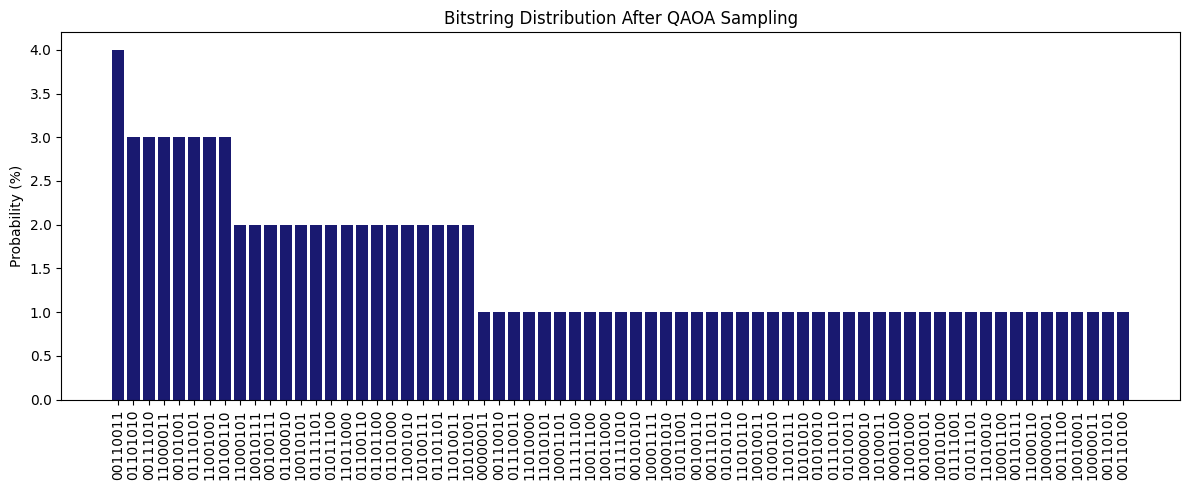

In [30]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# Step 1: Assign optimized parameters to circuit
optimized_circuit = candidate_circuit.assign_parameters(result.x, inplace=False) # inplace=True will modify the candidate_circuit

# Step 2: Sample from the optimized QAOA circuit
sampler = Sampler(mode=backend, options={"default_shots": 100})
job = sampler.run([(optimized_circuit,)])
result = job.result()

# Step 3: Get and normalize counts
counts_bin = result[0].data.meas.get_counts()
shots = result[0].data.meas.num_shots
final_distribution = {bit: val / shots for bit, val in counts_bin.items()}

# Step 4: Visualize the distribution (sorted by probability)
sorted_items = sorted(final_distribution.items(), key=lambda x: -x[1])
bitstrings, probs = zip(*sorted_items)

plt.figure(figsize=(12, 5))
plt.bar(bitstrings, [p * 100 for p in probs], color="midnightblue")
plt.xticks(rotation=90)
plt.ylabel("Probability (%)")
plt.title("Bitstring Distribution After QAOA Sampling")
plt.tight_layout()
plt.show()

> **Sensitivity and Expressivity Challenges in QAOA**
>
> The **Quantum Approximate Optimization Algorithm (QAOA)** output is highly sensitive to its **initial parameters** \((\beta, \gamma)\), as well as to the **choice of the initial quantum state**.  
This sensitivity often results in a fluctuating estimator of the expectation value of the cost Hamiltonian, complicating convergence and reproducibility.
>
> Furthermore, the **expressivity of the QAOA ansatz** introduces an additional challenge: as the depth of the circuit increases, the algorithm may encounter the so-called **barren plateau phenomenon**, where the variance of the cost function gradient decreases **exponentially** with system size.  
This renders parameter optimization increasingly difficult, limiting scalability in practice[6].

### Comparison with different optimizsers

Previously, we use COBYLA which is gradient free and known for small instances. Here we would like to experiment with different other types of optimizers.

By default, we use the same parameter as the previous section. Readers are invited to modify the following block should they wish to try other configurations.

In [31]:
# p = 2  # QAOA depth (increase to 2–4 once everything runs)
# ansatz = QAOAAnsatz(cost_operator=cost_h, reps=p, name="qaoa", flatten=True)
# assert ansatz.num_parameters == 2*p # Initial point length must be 2p.
# print(f"num_qubits      : {ansatz.num_qubits}")
# print(f"num_parameters  : {ansatz.num_parameters}")
# print(f"gate_count      : {ansatz.size()}")
# print(f"depth           : {ansatz.depth()}")
# ansatz.measure_all()
# ansatz.draw("mpl")
# # ---------- Step 2: Decompose + Transpile to Aer basis
# backend = AerSimulator()
# pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
# candidate_circuit = pm.run(ansatz.decompose(reps=1))
# candidate_circuit = transpile(candidate_circuit, backend=backend, optimization_level=1)
# # ---------- Step 3: Initial parameters [β_0..β_{p-1}, γ_0..γ_{p-1}] (QAOAAnsatz uses this ordering)
# # init_params = [np.pi/2]*p + [np.pi/4]*p
# init_params = np.random.uniform(-np.pi, np.pi, size=2*p)
# # init_params = np.random.uniform(0, np.pi/2, size=2*p)  #reduced search space
# # ---------- Step 4: Objective with EstimatorV2 
# estimator = AerEstimator()
# objective_vals = []
# def objective(params):
#     # Map observable to physical layout chosen by the transpiler, per EstimatorV2 docs. :contentReference[oaicite:2]{index=2}
#     # SA (Instruction Set Architecture) form, consistent with the actual circuit wiring.
#     isa_h = cost_h.apply_layout(candidate_circuit.layout) #the mapping from logical qubits → physical qubits chosen during transpilation.
#     job = estimator.run([(candidate_circuit, isa_h, [params])])  # one PUB
#     pub_res = job.result()[0]
#     ev = float(np.asarray(pub_res.data.evs)[0])  # scalar expectation value
#     objective_vals.append(ev)
#     return ev

We define a list of optimizers that we want to test and compare their results.

In [32]:
# Initialise the objective values
objective_vals = []
# --- List of optimizers to test
optimizers = {
    "Powell": {"options": {"maxiter": 300, "xtol": 1e-4, "ftol": 1e-4, "disp": False}},
    "COBYLA": {"options": {"maxiter": 300, "disp": False}},
    #"Nelder-Mead": {"options": {"maxiter": 300, "xatol": 1e-4, "fatol": 1e-4, "disp": False}},
    "L-BFGS-B": {"options": {"maxiter": 300, "disp": False}, "bounds": [(-np.pi, np.pi)] * (2*p)},
    "SLSQP": {"options": {"maxiter": 300, "ftol": 1e-6, "disp": False}, "bounds": [(-np.pi, np.pi)] * (2*p)},
}
# Initialise the retained results
all_results = {}
for method, cfg in optimizers.items():
    print(f"\n=== Optimizer: {method} ===")
    start = time.time()
    # Track energy evolution
    obj_vals = []

    def wrapped_objective(params):
        val = objective(params)
        obj_vals.append(val)
        return val

    # --- Run optimization
    if "bounds" in cfg:
        res = minimize(
            wrapped_objective,
            x0=np.array(init_params),
            method=method,
            options=cfg["options"],
            bounds=cfg["bounds"]
        )
    else:
        res = minimize(
            wrapped_objective,
            x0=np.array(init_params),
            method=method,
            options=cfg["options"]
        )

    # --- Average energy (expectation ⟨H⟩ at optimum)
    avg_energy = res.fun

    # --- Assign optimized parameters and sample bitstrings
    optimized = candidate_circuit.assign_parameters(res.x, inplace=False)
    sampler = AerSampler(default_shots=500, seed=42)
    job = sampler.run([(optimized,)])
    samples = job.result()[0]
    counts = samples.data.meas.get_counts()
    shots = samples.data.meas.num_shots
    final_distribution = {bit: c/shots for bit, c in counts.items()}

    # --- Best bitstring and energy
    best_bitstring = max(final_distribution, key=final_distribution.get)
    best_prob = final_distribution[best_bitstring]
    best_energy = Statevector.from_label(best_bitstring).expectation_value(cost_h).real

    end = time.time()
    print(f"Total timelap : {end-start}")
   
    # --- Save everything
    all_results[method] = {
        "initial_params": init_params,
        "final_params": res.x,
        "energy_evolution": obj_vals,
        "avg_energy": avg_energy,
        "best_bitstring": best_bitstring,
        "best_prob": best_prob,
        "best_energy": best_energy,
    }

    # --- Print summary
    print(f"Initial params: {init_params}")
    print(f"Final params  : {res.x}")
    print(f"Avg energy ⟨H⟩: {avg_energy}")
    print(f"Best bitstring: {best_bitstring} -- Prob: {round(best_prob, 3)} -- Energy: {round(best_energy, 3)}")

print(f"\n=== END ===")


=== Optimizer: Powell ===
Total timelap : 71.72606015205383
Initial params: [0.30670429 1.35207467 0.64568133 0.28200936]
Final params  : [1.21962238 1.46154517 0.30638173 0.79795701]
Avg energy ⟨H⟩: -2.282472873263889
Best bitstring: 00111001 -- Prob: 0.028 -- Energy: -2.748

=== Optimizer: COBYLA ===
Total timelap : 17.605881214141846
Initial params: [0.30670429 1.35207467 0.64568133 0.28200936]
Final params  : [ 1.98659267  0.72154097  0.43343106 -0.18232074]
Avg energy ⟨H⟩: -2.0544533962673612
Best bitstring: 00111001 -- Prob: 0.038 -- Energy: -2.748

=== Optimizer: L-BFGS-B ===
Total timelap : 33.49744534492493
Initial params: [0.30670429 1.35207467 0.64568133 0.28200936]
Final params  : [0.30670214 1.35207578 0.64568289 0.28200722]
Avg energy ⟨H⟩: 2.3113924153645833
Best bitstring: 00001111 -- Prob: 0.05 -- Energy: 7.415

=== Optimizer: SLSQP ===
Total timelap : 1.5957715511322021
Initial params: [0.30670429 1.35207467 0.64568133 0.28200936]
Final params  : [0.30670429 1.3520746

### Complexity analysis

Here we analyze how the QAOA circuit scales with the number of assets and the algorithm depth $p$. We examine both the total number of gates and the circuit depth to understand resource requirements for different portfolio sizes and QAOA configurations.

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  10 of 10 completed


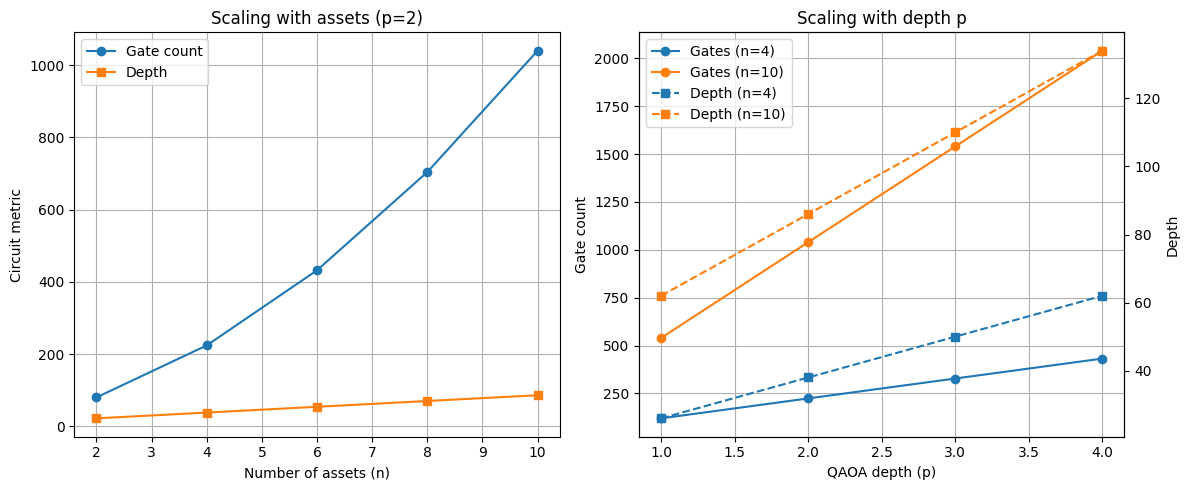

In [33]:
def qaoa_stats(cost_h, p):
    ansatz = QAOAAnsatz(cost_operator=cost_h, reps=p, flatten=True)
    return ansatz.size(), ansatz.depth(), ansatz.num_qubits

p_fixed = 2
sizes_left = [2, 4, 6, 8, 10]   # pick any subset <= len(tickers)
tickers = ["AAPL", "MSFT", "GOOGL", "TSLA", "AMZN", "NVDA", "GS", "MS", "KO", "NKE"]
n_assets, gate_counts, depths = [], [], []
for n in sizes_left:
    portfolio = create_finance_example(tickers=tickers[:n]) # Kernal will die if too much assets
    bqm, H, order, offset = build_qubo_dynamic_from_portfolio_model(portfolio)
    linear, quadratic, offset = bqm.to_ising()
    order = list(bqm.variables)                # bqm.variables gives your [('x',t,i,q), ...]
    index_of = {v: k for k, v in enumerate(order)}
    cost_h, const = ising_to_pauli(linear, quadratic, offset, index_of)
    #cost_h = build_cost_h_for_tickers(tickers)   # <<< replace with your existing code
    
    g, d, nq = qaoa_stats(cost_h, p_fixed)
    n_assets.append(n)           # x-axis = number of assets (use nq if you prefer qubits)
    gate_counts.append(g)
    depths.append(d)

# ---- RIGHT: scaling with depth p for two fixed asset sizes ----
asset_sizes_right = [4, 10]     # choose the two asset counts you want to show
p_list = [1, 2, 3, 4]           # depths to compare

series = {}
for n in asset_sizes_right:
    portfolio = create_finance_example(tickers=tickers[:n])
    bqm, H, order, offset = build_qubo_dynamic_from_portfolio_model(portfolio)
    linear, quadratic, offset = bqm.to_ising()
    order = list(bqm.variables)               
    index_of = {v: k for k, v in enumerate(order)}
    cost_h, const = ising_to_pauli(linear, quadratic, offset, index_of)
    gates_p, depths_p = [], []
    for p in p_list:
        g, d, _ = qaoa_stats(cost_h, p)
        gates_p.append(g)
        depths_p.append(d)
    series[n] = {"gates": gates_p, "depths": depths_p}

# ---- Plot ----
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Left panel
axs[0].plot(n_assets, gate_counts, marker='o', label="Gate count")
axs[0].plot(n_assets, depths,     marker='s', label="Depth")
axs[0].set_xlabel("Number of assets (n)")   # or "Number of qubits" if you prefer nq
axs[0].set_ylabel("Circuit metric")
axs[0].set_title(f"Scaling with assets (p={p_fixed})")
axs[0].grid(True); axs[0].legend()

# Right panel (dual y-axes: gate count primary, depth secondary)
ax1 = axs[1]
ax2 = ax1.twinx()
for n in asset_sizes_right:
    ax1.plot(p_list, series[n]["gates"], marker='o', label=f"Gates (n={n})")
    ax2.plot(p_list, series[n]["depths"], marker='s', linestyle='--', label=f"Depth (n={n})")

ax1.set_xlabel("QAOA depth (p)")
ax1.set_ylabel("Gate count")
ax2.set_ylabel("Depth")
ax1.set_title("Scaling with depth p")
ax1.grid(True)

# unified legend
h1,l1 = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
axs[1].legend(h1+h2, l1+l2, loc='best')

plt.tight_layout()
plt.show()

The above figures evaluate the scaling of QAOA circuits for portfolio optimization. On the left, we show how the number of gates and circuit depth grow with the number of assets at a fixed QAOA depth $p$. On the right, we illustrate how gate counts and depth increase with QAOA depth $p$ for two fixed asset sizes, highlighting the trade-off between circuit complexity and algorithmic precision.

# Perspective

Building on our findings, we note that **QAOA suffers from non-negligible limitations** in practice, including parameter sensitivity, instability, and barren plateau effects. In contrast, **VQE has shown empirically better performance and greater stability**, making it the most promising approach for near-term applications. Consequently, our next objective is to move beyond standard QUBO reductions and investigate **non-QUBO formulations implemented via Variational Quantum Algorithms (VQAs)**, which offer both practical executability and improved modeling flexibility.

* **Variational quantum algorithms (VQAs) for non-QUBO formulations:**

During our literature review, we came across formulations that are not expressed in the form of a QUBO. In theory, VQAs could be applied to address these problems. For example:

$$
  \textbf{(P)}\quad \min_{ (x_t) \in \mathbb{R}_+^{\aleph}} \sum_{t=0}^{N_T-1}\frac{x_t^{\top}\Sigma_t x_t}{\Vert x_t\Vert_1^2} - \lambda\, \mu_t^{\top}\frac{x_t}{\Vert x \Vert_1} + \eta_t \Vert x_t - x_{t-1}\Vert_2^2,
$$
where $\aleph = N_T \times N \times (N_q+1)$ and $x_{-1} = 0$.
The objective function is homothety-invariant, which allows relaxation of the weight summation constraint at the cost of added nonlinearity. Potential approaches include sampling techniques such as CVaR (as in IBM's recent work by Agliardi et al.[2]) or shallow bosonic circuits (Bradler et al.[3]).


* **Continuous dynamic portfolio optimization:** The current discretized workflow in this notebook is an approximation of the continuous-time problem, usually formulated as a Hamilton–Jacobi–Bellman (HJB) equation. Because the HJB equatrion is very hard to solve in high dimensions due to its nonlinearity, one possible route is to approximate it with the Schrödingerisation technique introduced by Jin et al.[4].



* **Quantum Monte Carlo for forecasting:** Apply quantum amplitude estimation to accelerate Monte Carlo simulations for multi-step forecasts of returns and covariance matrices.

* **Benchmarking:** Compare our quantum framework with classical solvers using available tools such as GEEKO and PyPortfolioOpt, focusing on performance and robustness.

* **Energy consumption:**  Assess the energy use of IBM QPU hardware relative to classical frameworks, to evaluate both speedup and potential efficiency gains.

* **Long–short portfolio optimization:** Extend beyond long-only portfolios by allowing short-selling, i.e. negative weights, to better reflect realistic investment strategies.



# Conclusion
Congratulations on making it this far! We hope you enjoyed the journey :D

If you skipped the notebook and came straight here, let us give you a brief summary of our work:

In this notebook, we present a new formulation of the portfolio optimization problem. We explore two of the most popular quantum approaches, [VQE](#VQE) and [QAOA](#QAOA), by adapting the problem into [QUBO](#QUBO-contruction) form. We not only demonstrate how to simulate these methods with Qiskit, but also provide explanations of the results we observed.

Moreover, we discuss possible directions for tackling the problem in its natural form (not necessarily quadratic and including constraints). While the proposed framework is illustrated on a special case, it is designed to be easily extended to other portfolio optimization settings.

# References
* [1] Farhi et al., [A Quantum Approximate Optimization Algorithm](https://arxiv.org/abs/1411.4028)
* [2] Agliardi et al., [Portfolio construction using a sampling-based variational quantum scheme](https://arxiv.org/abs/2508.13557) 
* [3] Bradler et al., [Certain properties and applications of shallow bosonic circuits](https://arxiv.org/abs/2112.09766)
* [4] Jin et al., [Quantum simulation of partial differential equations via Schrodingerisation](https://arxiv.org/abs/2212.13969)
* [5] Innan et al., [Quantum Portfolio Optimization with Expert Analysis Evaluation](https://arxiv.org/abs/2507.20532)
* [6] Cerezo et al., [Cost function dependent barren plateaus in shallow parametrized quantum circuits](https://arxiv.org/abs/2001.00550)


<font size="+2">Versions</font><br>

In [34]:
import sys, qiskit, qiskit_aer, qiskit_algorithms
print(sys.version)
print(f"qiskit = {qiskit.__version__}")
print(f"aer    = {qiskit_aer.__version__}")
print(f"algos  = {qiskit_algorithms.__version__}")

3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:40:35) [GCC 12.3.0]
qiskit = 2.2.1
aer    = 0.17.2
algos  = 0.4.0
